In [2]:
import pandas as pd
import numpy as np
import keras
from keras.models import Sequential
from sklearn.utils import shuffle
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix, matthews_corrcoef, accuracy_score, roc_auc_score, roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from Bio import SeqIO
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, Dropout, MaxPooling1D, Flatten, Dense
import os
import random


In [3]:
# Function to set seeds for reproducibility
def set_seed(seed_value=42):
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)

# Set seed for reproducibility
set_seed(42)

# Set deterministic operations in TensorFlow
os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [5]:
train_x = []
train_y = []
r_test_x = []
r_test_y = []
posit_1 = 1;
negat_0 = 0;
win_size = 33 # actual window size
win_size_kernel = int(win_size/2 + 1)


# define universe of possible input values
alphabet = 'ARNDCQEGHILKMFPSTWYV-'

# define a mapping of chars to integers
char_to_int = dict((c, i) for i, c in enumerate(alphabet))
int_to_char = dict((i, c) for i, c in enumerate(alphabet))

# TRAIN DATASET -------------------------------------------------------------
#for positive sequence
def inner1():
    #Input
    data = seq_record.seq
    #rint(data) 
    # integer encode input data
    for char in data:
        if char not in alphabet:
            return
    integer_encoded = [char_to_int[char] for char in data]
    train_x.append(integer_encoded)
    train_y.append(posit_1)
for seq_record in SeqIO.parse("data/train/fasta/positive_sites.fasta", "fasta"): # training data positive
    inner1()
#for negative sequence
def inner2():
    #Input
    data = seq_record.seq
    #print(data) 
    # integer encode input data
    for char in data:
        if char not in alphabet:
            return
    integer_encoded = [char_to_int[char] for char in data]
    train_x.append(integer_encoded)
    train_y.append(negat_0)
for seq_record in SeqIO.parse("data/train/fasta/negative_sites.fasta", "fasta"): # training data negative
    inner2()
# Changing to array (matrix)    
train_x = np.array(train_x)
train_y = np.array(train_y)


#-------------------------TEST DATASET----------------------------------------
#for positive sequence
def innertest1():
    #Input
    data = seq_record.seq
    #rint(data) 
    # integer encode input data
    for char in data:
        if char not in alphabet:
            return
    integer_encoded = [char_to_int[char] for char in data]
    r_test_x.append(integer_encoded)
    r_test_y.append(posit_1)
for seq_record in SeqIO.parse("data/test/fasta/test_positive_sites.fasta", "fasta"): # test positive
    innertest1()
#for negative sequence
def innertest2():
    #Input
    data = seq_record.seq
    #print(data) 
    # integer encode input data
    for char in data:
        if char not in alphabet:
            return
    integer_encoded = [char_to_int[char] for char in data]
    r_test_x.append(integer_encoded)
    r_test_y.append(negat_0)
for seq_record in SeqIO.parse("data/test/fasta/test_negative_sites.fasta", "fasta"): # test negative
    innertest2()

r_test_x = np.array(r_test_x)
r_test_y = np.array(r_test_y)


# epochs = 100
# num_classes = 2
# batch_size = 256
# optimize_2 = tf.keras.optimizers.Adam()

# loss_2 = tf.keras.losses.binary_crossentropy

# test_size = 0.2
seed = 3

X_train = train_x
y_train = train_y

X_test = r_test_x
y_test = r_test_y


print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


(9499, 33)
(9499,)
(3226, 33)
(3226,)


In [7]:
train_positive_pt5 = pd.read_csv("data/train/features/train_positive_ProtT5-XL-UniRef50.csv", header = None).iloc[:,2:]
train_negative_pt5 = pd.read_csv("data/train/features/train_negative_ProtT5-XL-UniRef50.csv", header = None).iloc[:,2:]
test_positive_pt5 = pd.read_csv("data/test/features/test_positive_ProtT5-XL-UniRef50.csv", header = None).iloc[:,2:]
test_negative_pt5 = pd.read_csv("data/test/features/test_negative_ProtT5-XL-UniRef50.csv", header = None).iloc[:,2:]


# create labels
train_positive_labels = np.ones(train_positive_pt5.shape[0])
train_negative_labels = np.zeros(train_negative_pt5.shape[0])
test_positive_labels = np.ones(test_positive_pt5.shape[0])
test_negative_labels = np.zeros(test_negative_pt5.shape[0])

# stack positive and negative data together
X_train_pt5 = np.vstack((train_positive_pt5,train_negative_pt5))
X_test_pt5 = np.vstack((test_positive_pt5,test_negative_pt5))
y_train_pt5 = np.concatenate((train_positive_labels, train_negative_labels), axis = 0)
y_test_pt5 = np.concatenate((test_positive_labels, test_negative_labels), axis = 0)

# # shuffle X and y together
# X_train_pt5, y_train_pt5 = shuffle(X_train_pt5, y_train_pt5)
# X_test_pt5, y_test_pt5 = shuffle(X_test_pt5, y_test_pt5)
print(X_train_pt5.shape)
print(y_train_pt5.shape)
print(X_test_pt5.shape)
print(y_test_pt5.shape)

(9499, 1024)
(9499,)
(3226, 1024)
(3226,)


In [8]:
from sklearn.model_selection import train_test_split

# Define the split ratio and random state for reproducibility
split_ratio = 0.1
random_state = 42

# Perform the split on the smaller dataset (X_train_pt5, y_train_pt5)
X_train_pt5, X_val_pt5, y_train_pt5, y_val_pt5 = train_test_split(
    X_train_pt5, y_train_pt5, test_size=split_ratio, random_state=random_state, stratify=y_train_pt5)

# Use the same indices to split the larger dataset (X_train, y_train)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=split_ratio, random_state=random_state, stratify=y_train)

# Now, both X_val_pt5 and X_val correspond to the same split in y_train_pt5 and y_train
print( y_val[:10])
print( y_val_pt5[:10])

# X_test = X_test[:2000]
# y_test = y_test[:2000]
# X_test_pt5 = X_test_pt5[:2000]
# y_test_pt5 = y_test_pt5[:2000]

[0 0 0 1 1 0 0 1 1 1]
[0. 0. 0. 1. 1. 0. 0. 1. 1. 1.]


In [9]:
def plot(history):
    # learning curves of model accuracy
    plt.plot(history.history['accuracy'], label='train_acc')
    plt.plot(history.history['val_accuracy'], label='val_acc')
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.legend()
    plt.show()

In [10]:
from sklearn.metrics import accuracy_score, matthews_corrcoef, roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
def evaluate_model(model, X_val = None, X_val_pt5 = None, y_val=None):
    y_true = y_val
    # Predict probabilities (or logits if using `from_logits=True`).
    if X_val_pt5 is None:
        y_pred_probs = model.predict(X_val)
    elif X_val is None:
        y_pred_probs = model.predict(X_val_pt5)
    else:
        y_pred_probs = model.predict([X_val, X_val_pt5])

    # Convert probabilities/logits to binary predictions (threshold = 0.5).
    y_pred = (y_pred_probs > 0.5).astype(int)

    # If y_true is one-hot encoded, convert it to binary format
    if len(y_true.shape) > 1 and y_true.shape[1] > 1:  # Check if y_true is one-hot encoded
        y_true = np.argmax(y_true, axis=1)  # Convert one-hot encoded y_true to binary labels

    # Ensure y_pred is also 1D
    if len(y_pred.shape) > 1 and y_pred.shape[1] > 1:
        y_pred = np.argmax(y_pred, axis=1)  # Convert y_pred to binary labels if necessary

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    # Compute Specificity
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)

    # Print the results
    print(f'Accuracy: {accuracy}')
    print(f'MCC: {mcc}')
    print(f'AUC: {auc}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'Specificity: {specificity}')
    print(f'F1: {f1}')

    return accuracy, mcc, auc, precision, recall, specificity, f1

In [43]:
import pandas as pd
import numpy as np

# Read test and train data
test_df = pd.read_csv("PTMGPT2-datasets/Succinylation (K)/benchmark.csv")
train_df = pd.read_csv("PTMGPT2-datasets/Succinylation (K)/training.csv")[:35000]

test_x = test_df['Seq'].values
test_y = test_df['Label'].values

train_x = train_df['Seq'].values
train_y = train_df['Label'].values

# Include the '-' character for padding
unique_chars = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', 'X', 'U', 'B', '-']
char_to_int = {char: idx for idx, char in enumerate(unique_chars)}

# Convert sequences to integers
def seq_to_int(seq):
    return [char_to_int[char] for char in seq]

# Pad the sequences to the same length
def pad_sequence(seq, max_length):
    return seq + [char_to_int['-']] * (max_length - len(seq))

# Truncate or pad sequences to the first 21 characters
train_x = [seq_to_int(seq[:21]) for seq in train_x]
test_x = [seq_to_int(seq[:21]) for seq in test_x]

# Get the maximum sequence length (in this case it's always 21, but we'll keep this step for flexibility)
max_length = max(len(seq) for seq in train_x + test_x)

# Pad sequences to max length (though truncation ensures they are of uniform length)
train_x = [pad_sequence(seq, max_length) for seq in train_x]
test_x = [pad_sequence(seq, max_length) for seq in test_x]

# Convert to numpy arrays
train_x = np.array(train_x)
test_x = np.array(test_x)
train_y = np.array(train_y)
test_y = np.array(test_y)

#train val split
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.2, random_state=42)

# Optional: Print shapes to confirm data preparation
print("Train X shape:", train_x.shape)
print("Test X shape:", test_x.shape)
print("Train Y shape:", train_y.shape)
print("Test Y shape:", test_y.shape)
print("Val X shape:", val_x.shape)
print("Val Y shape:", val_y.shape)


Train X shape: (28000, 21)
Test X shape: (1435, 21)
Train Y shape: (28000,)
Test Y shape: (1435,)
Val X shape: (7000, 21)
Val Y shape: (7000,)


C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_14 (Conv1D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_15 (Conv1D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5794 - loss: 0.6736 - val_accuracy: 0.6120 - val_loss: 0.6531
Epoch 2/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6285 - loss: 0.6410 - val_accuracy: 0.6800 - val_loss: 0.6097
Epoch 3/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6692 - loss: 0.6053 - val_accuracy: 0.6954 - val_loss: 0.6014
Epoch 4/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6732 - loss: 0.5943 - val_accuracy: 0.6959 - val_loss: 0.5947
Epoch 5/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6864 - loss: 0.5872 - val_accuracy: 0.7073 - val_loss: 0.5888
Epoch 6/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6977 - loss: 0.5794 - val_accuracy: 0.7040 - val_loss: 0.5826
Epoch 7/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6985 - loss: 0.5781 - val_accuracy: 0.7056 - val_loss: 0.5779
Epoch 8/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6991 - loss: 0.5774 - val_accu

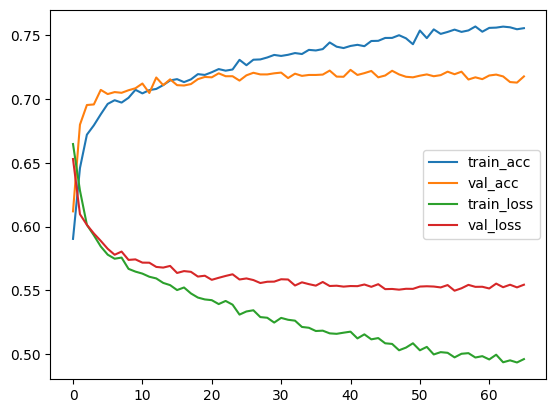

219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.7195714285714285
MCC: 0.42326497298897686
AUC: 0.7102191037743923
Precision: 0.6783954961294862
Recall: 0.6476318441383944
Specificity: 0.7728063634103902
F1: 0.6626568138855473
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Accuracy: 0.7268292682926829
MCC: 0.41143692221679984
AUC: 0.7215938042575678
Precision: 0.5212014134275619
Recall: 0.7091346153846154
Specificity: 0.7340529931305201
F1: 0.6008146639511202


(0.7268292682926829,
 0.41143692221679984,
 0.7215938042575678,
 0.5212014134275619,
 0.7091346153846154,
 0.7340529931305201,
 0.6008146639511202)

In [45]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, Dropout, MaxPooling1D, Flatten, Dense

def conv1d_model():
    
    model = Sequential()
    
    # Embedding layer
    model.add(Embedding(64, 24, input_length=21))
    
    # Conv1D and Dropout layers
    model.add(Conv1D(64, kernel_size=9, activation='relu', kernel_initializer='he_normal', padding='valid'))
    model.add(Dropout(0.6))
    
    model.add(Conv1D(128, kernel_size=3, activation='relu', kernel_initializer='he_normal', padding='same'))
    model.add(Dropout(0.6))
    
    # MaxPooling, Flatten, and Dense layers
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    
    # model.add(Dense(64, activation='relu', kernel_initializer='he_normal'))
    # model.add(Dropout(0.2))
    
    model.add(Dense(16, activation='relu', kernel_initializer='he_normal'))
    model.add(Dropout(0.2))
    
    # Output layer
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile model
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss=BinaryCrossentropy(),
                  metrics=['accuracy'])
    
    return model


conv1d_model = conv1d_model()
conv1d_model.summary()

# Fit the model
history = conv1d_model.fit(train_x, train_y, epochs=100, batch_size=64, verbose=1,
                            validation_data=(val_x, val_y), 
                            callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]) 

plot(history)

# Evaluate the model
evaluate_model(conv1d_model, X_val=val_x, y_val=val_y)
evaluate_model(conv1d_model, X_val_pt5=test_x, y_val=test_y)
